# Project 2: Personalized Recommendation System

This notebook implements a complete workflow to build and evaluate a **personalized recommendation engine**.

## What you'll get
- Data loading (MovieLens-style ratings if available, otherwise synthetic)
- EDA (distributions, sparsity)
- Baselines (global mean, user mean, item mean)
- Collaborative filtering (user-based & item-based with cosine similarity)
- Matrix factorization (TruncatedSVD & NMF)
- Content-based (TF–IDF on item metadata if available)
- Hybrid scoring (blend CF + content)
- Evaluation: RMSE, MAE, and Precision@K
- Recommendation demo for a target user

> **Tip:** Place MovieLens-like files (`ratings.csv`, `movies.csv`) in the same folder to use real data. Otherwise the notebook will create a small synthetic dataset.


In [1]:
# ==== Setup ====
import os
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

RNG = np.random.default_rng(42)
pd.set_option('display.max_columns', None)


## 1) Load Data
Tries to read `ratings.csv` (`userId,itemId,rating,timestamp?`) and optional `movies.csv` (`itemId,title,genres`). If not found, a synthetic dataset is generated.

In [2]:
def load_or_make_data():
    ratings_path = 'ratings.csv'
    items_path = 'movies.csv'
    if os.path.exists(ratings_path):
        ratings = pd.read_csv(ratings_path)
        # Try to standardize column names
        cols = {c.lower(): c for c in ratings.columns}
        # map typical names
        rename = {}
        for c in ratings.columns:
            cl = c.lower()
            if cl in ('userid','user','u_id','u'): rename[c] = 'userId'
            if cl in ('movieid','itemid','item','i_id','i'): rename[c] = 'itemId'
            if cl in ('rating','score','stars'): rename[c] = 'rating'
        ratings = ratings.rename(columns=rename)
        needed = {'userId','itemId','rating'}
        if not needed.issubset(ratings.columns):
            raise ValueError("ratings.csv must contain userId, itemId, rating columns")
        # Optional items
        items = None
        if os.path.exists(items_path):
            items = pd.read_csv(items_path)
            ren = {}
            for c in items.columns:
                cl = c.lower()
                if cl in ('movieid','itemid','item','i_id','i'): ren[c] = 'itemId'
                if cl in ('title','name'): ren[c] = 'title'
                if cl in ('genres','tags','category'): ren[c] = 'genres'
            items = items.rename(columns=ren)
        return ratings, items, False
    else:
        # synthetic data
        n_users, n_items = 200, 300
        density = 0.06  # ~6% observed ratings
        n_obs = int(n_users*n_items*density)
        users = RNG.integers(1, n_users+1, size=n_obs)
        items = RNG.integers(1, n_items+1, size=n_obs)
        # latent preference model
        user_latent = RNG.normal(0, 1, size=(n_users, 10))
        item_latent = RNG.normal(0, 1, size=(n_items, 10))
        base = (user_latent[users-1] * item_latent[items-1]).sum(axis=1)
        noise = RNG.normal(0, 0.5, size=n_obs)
        raw = base + noise
        ratings_vals = np.clip(3 + raw, 0.5, 5.0)
        ratings = pd.DataFrame({'userId': users, 'itemId': items, 'rating': np.round(ratings_vals, 1)})
        # synthetic items/meta
        genres_list = ['Action','Comedy','Drama','Sci-Fi','Romance','Thriller','Animation','Documentary']
        item_meta = pd.DataFrame({
            'itemId': np.arange(1, n_items+1),
            'title': [f'Item {i}' for i in range(1, n_items+1)],
            'genres': [', '.join(RNG.choice(genres_list, size=RNG.integers(1,4), replace=False)) for _ in range(n_items)]
        })
        return ratings, item_meta, True

ratings, items, synthetic = load_or_make_data()
print('Ratings shape:', ratings.shape, '| Items present:', items is not None, '| Synthetic:', synthetic)
ratings.head()


Ratings shape: (3600, 3) | Items present: True | Synthetic: True


,userId,itemId,rating
0,18,134,0.5
1,155,184,3.0
2,131,47,0.5
3,88,188,5.0
4,87,278,4.4


## 2) Basic EDA

Users: 200 | Items: 300 | Observed ratings: 3600 | Sparsity: 0.940


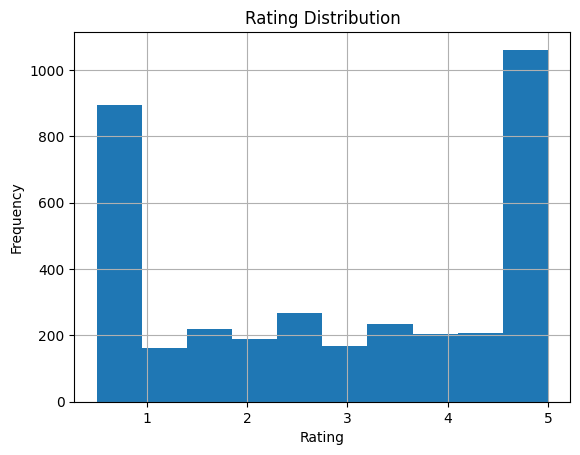

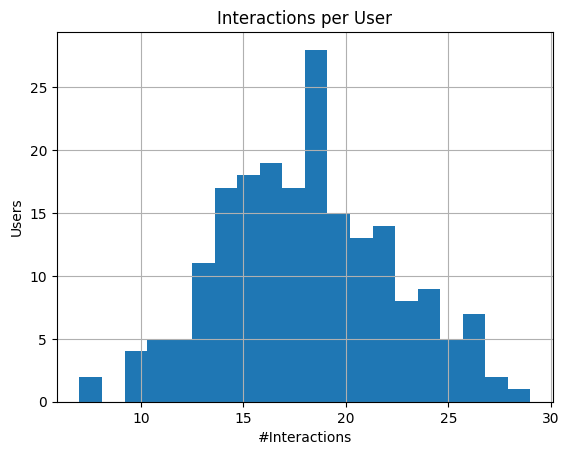

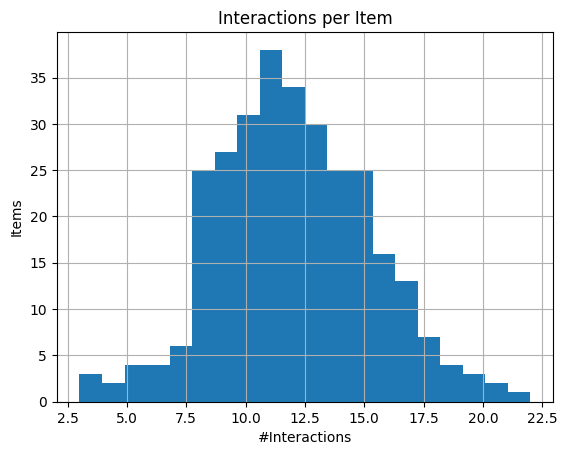

In [3]:
n_users = ratings['userId'].nunique()
n_items = ratings['itemId'].nunique()
sparsity = 1 - (len(ratings) / (n_users * n_items))
print(f"Users: {n_users} | Items: {n_items} | Observed ratings: {len(ratings)} | Sparsity: {sparsity:.3f}")

# Rating distribution
plt.figure()
ratings['rating'].hist(bins=10)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Interactions per user
plt.figure()
ratings.groupby('userId').size().hist(bins=20)
plt.title('Interactions per User')
plt.xlabel('#Interactions')
plt.ylabel('Users')
plt.show()

# Interactions per item
plt.figure()
ratings.groupby('itemId').size().hist(bins=20)
plt.title('Interactions per Item')
plt.xlabel('#Interactions')
plt.ylabel('Items')
plt.show()


## 3) Train/Test Split

In [4]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)
print(train.shape, test.shape)


(2880, 3) (720, 3)


## 4) Utility functions

In [5]:
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def precision_at_k(recommended, ground_truth, k=10):
    if k == 0:
        return 0.0
    rec_k = recommended[:k]
    return len(set(rec_k) & set(ground_truth)) / k

def make_indexers(df):
    users = df['userId'].unique()
    items = df['itemId'].unique()
    u2i = {u:i for i,u in enumerate(users)}
    i2i = {i:j for j,i in enumerate(items)}
    return u2i, i2i, users, items

def build_matrix(df, u2i, i2i):
    rows = df['userId'].map(u2i)
    cols = df['itemId'].map(i2i)
    data = df['rating'].astype(float)
    return csr_matrix((data, (rows, cols)), shape=(len(u2i), len(i2i)))

u2i, i2i, users_arr, items_arr = make_indexers(train)
R = build_matrix(train, u2i, i2i)
R


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2812 stored elements and shape (200, 300)>

## 5) Baseline Predictors
- **Global Mean**
- **User Mean**
- **Item Mean**

In [6]:
global_mean = train['rating'].mean()
user_mean = train.groupby('userId')['rating'].mean().to_dict()
item_mean = train.groupby('itemId')['rating'].mean().to_dict()

def predict_baseline(row, mode='global'):
    u, i = row['userId'], row['itemId']
    if mode == 'global':
        return global_mean
    elif mode == 'user':
        return user_mean.get(u, global_mean)
    elif mode == 'item':
        return item_mean.get(i, global_mean)
    else:
        raise ValueError('Unknown mode')

for m in ['global','user','item']:
    preds = test.apply(lambda r: predict_baseline(r, m), axis=1)
    print(m, 'RMSE:', rmse(test['rating'], preds), '| MAE:', mean_absolute_error(test['rating'], preds))


global RMSE: 1.7655946288904325 | MAE: 1.5978014081790124
user RMSE: 1.849086792341069 | MAE: 1.6317681801817028
item RMSE: 1.8611207319361043 | MAE: 1.6156329165229288


## 6) Collaborative Filtering (Cosine Similarity)
**User-based** and **Item-based** predictors.

In [7]:
# Precompute similarities
user_sim = cosine_similarity(R)
item_sim = cosine_similarity(R.T)

def cf_predict(u, i, mode='user', k=20):
    if u not in u2i or i not in i2i:
        return global_mean
    u_idx, i_idx = u2i[u], i2i[i]
    if mode == 'user':
        sims = user_sim[u_idx]
        # ratings of neighbors for this item
        col = R[:, i_idx].toarray().ravel()
        rated = col > 0
        sims = sims[rated]
        col = col[rated]
        if len(col) == 0:
            return user_mean.get(u, global_mean)
        top = np.argsort(-sims)[:k]
        sims_top = sims[top]
        vals_top = col[top]
        denom = np.abs(sims_top).sum() + 1e-9
        return (sims_top @ vals_top) / denom
    elif mode == 'item':
        sims = item_sim[i_idx]
        # ratings of this user for neighbor items
        row = R[u_idx].toarray().ravel()
        rated = row > 0
        sims = sims[rated]
        row = row[rated]
        if len(row) == 0:
            return item_mean.get(i, global_mean)
        top = np.argsort(-sims)[:k]
        sims_top = sims[top]
        vals_top = row[top]
        denom = np.abs(sims_top).sum() + 1e-9
        return (sims_top @ vals_top) / denom
    else:
        raise ValueError('mode must be user or item')

for mode in ['user','item']:
    preds = test.apply(lambda r: cf_predict(r['userId'], r['itemId'], mode=mode, k=30), axis=1)
    print(mode, 'CF RMSE:', rmse(test['rating'], preds), '| MAE:', mean_absolute_error(test['rating'], preds))


user CF RMSE: 2.13026869532639 | MAE: 1.7484614045138889
item CF RMSE: 2.0908253499105545 | MAE: 1.7309383539238716


## 7) Matrix Factorization (TruncatedSVD & NMF)

In [8]:
k_factors = 40 if min(R.shape) >= 50 else max(2, min(R.shape)//2)

# TruncatedSVD on (user x item) matrix
svd = TruncatedSVD(n_components=k_factors, random_state=42)
U = svd.fit_transform(R)
V = svd.components_

def svd_predict(u, i):
    if u not in u2i or i not in i2i:
        return global_mean
    return np.dot(U[u2i[u]], V[:, i2i[i]])

svd_preds = test.apply(lambda r: svd_predict(r['userId'], r['itemId']), axis=1)
print('TruncatedSVD RMSE:', rmse(test['rating'], svd_preds), '| MAE:', mean_absolute_error(test['rating'], svd_preds))

# NMF (non-negative). Shift ratings to be non-negative
min_rating = train['rating'].min()
R_shift = R.copy().astype(float)
R_shift.data = R_shift.data - min_rating + 1e-6
nmf = NMF(n_components=min(50, k_factors), init='nndsvda', random_state=42, max_iter=300)
W = nmf.fit_transform(R_shift)
H = nmf.components_

def nmf_predict(u, i):
    if u not in u2i or i not in i2i:
        return global_mean
    val = np.dot(W[u2i[u]], H[:, i2i[i]]) + min_rating
    return float(val)

nmf_preds = test.apply(lambda r: nmf_predict(r['userId'], r['itemId']), axis=1)
print('NMF RMSE:', rmse(test['rating'], nmf_preds), '| MAE:', mean_absolute_error(test['rating'], nmf_preds))


TruncatedSVD RMSE: 3.1515082153233416 | MAE: 2.604377272491824
NMF RMSE: 2.7074329739230794 | MAE: 2.118478196308101


## 8) Content-Based (TF–IDF) — Optional if metadata present
If an item metadata table with a `genres` (or keywords) column exists, we compute item-item similarities and score items for each user.

In [9]:
content_available = items is not None and 'genres' in items.columns
print('Content metadata available:', content_available)

if content_available:
    tfidf = TfidfVectorizer(token_pattern=r'[^, ]+')
    tfidf_m = tfidf.fit_transform(items['genres'].fillna(''))
    content_sim = cosine_similarity(tfidf_m)
    id2idx = {itm: idx for idx, itm in enumerate(items['itemId'])}
else:
    content_sim = None
    id2idx = {}

def content_score_for_user(u, known_df, top_k=100):
    if not content_available:
        return {}
    user_hist = known_df[known_df['userId']==u]
    scored = {}
    for _, row in user_hist.iterrows():
        i = row['itemId']
        if i not in id2idx:
            continue
        sims = content_sim[id2idx[i]]
        for j_idx, s in enumerate(sims):
            j = items.iloc[j_idx]['itemId']
            if j == i:
                continue
            scored[j] = scored.get(j, 0.0) + float(s)
    # return top_k
    return dict(sorted(scored.items(), key=lambda kv: kv[1], reverse=True)[:top_k])


Content metadata available: True


## 9) Top-N Recommendations & Precision@K
We build a recommender using a **hybrid score**: `alpha * CF_item + (1-alpha) * content_score` (if content is available). Otherwise, we use CF only.

In [10]:
def topn_for_user(u, known_df, alpha=0.7, N=10):
    # candidate items = all items not yet rated by user in known_df
    rated_items = set(known_df[known_df['userId']==u]['itemId'].tolist())
    all_items = set(train['itemId'].unique()).union(set(test['itemId'].unique()))
    candidates = list(all_items - rated_items)
    # CF item-based score
    cf_scores = {}
    for i in candidates:
        cf_scores[i] = cf_predict(u, i, mode='item', k=30)
    # Content score
    content_scores = content_score_for_user(u, known_df) if content_available else {}
    # Normalize dictionaries
    if cf_scores:
        cf_vals = np.array(list(cf_scores.values()))
        cf_min, cf_max = cf_vals.min(), cf_vals.max()
        denom = (cf_max - cf_min) if (cf_max > cf_min) else 1.0
        for k in cf_scores:
            cf_scores[k] = (cf_scores[k] - cf_min) / denom
    if content_scores:
        cs_vals = np.array(list(content_scores.values()))
        cs_min, cs_max = cs_vals.min(), cs_vals.max()
        denom = (cs_max - cs_min) if (cs_max > cs_min) else 1.0
        for k in content_scores:
            content_scores[k] = (content_scores[k] - cs_min) / denom
    # Hybrid
    final_scores = {}
    for i in candidates:
        s_cf = cf_scores.get(i, 0)
        s_ct = content_scores.get(i, 0)
        final_scores[i] = alpha * s_cf + (1 - alpha) * s_ct
    top_items = [k for k,_ in sorted(final_scores.items(), key=lambda kv: kv[1], reverse=True)[:N]]
    return top_items

def build_ground_truth(test_df):
    # items with rating >= threshold are considered relevant
    thr = max(4.0, test_df['rating'].quantile(0.7))
    gt = test_df[test_df['rating'] >= thr].groupby('userId')['itemId'].apply(list).to_dict()
    return gt

ground_truth = build_ground_truth(test)
users_eval = list(ground_truth.keys())[:100]
precisions = []
for u in users_eval:
    recs = topn_for_user(u, train, alpha=0.7, N=10)
    precisions.append(precision_at_k(recs, ground_truth.get(u, []), k=10))
print('Precision@10 (hybrid/CF):', np.mean(precisions) if precisions else 'N/A')


Precision@10 (hybrid/CF): 0.008


## 10) Compare Rating-Prediction Models

In [11]:
results = []
def add_result(name, y_pred):
    results.append({
        'Model': name,
        'RMSE': rmse(test['rating'], y_pred),
        'MAE': mean_absolute_error(test['rating'], y_pred)
    })

add_result('GlobalMean', test.apply(lambda r: predict_baseline(r, 'global'), axis=1))
add_result('UserMean', test.apply(lambda r: predict_baseline(r, 'user'), axis=1))
add_result('ItemMean', test.apply(lambda r: predict_baseline(r, 'item'), axis=1))
add_result('CF-User', test.apply(lambda r: cf_predict(r['userId'], r['itemId'], mode='user', k=30), axis=1))
add_result('CF-Item', test.apply(lambda r: cf_predict(r['userId'], r['itemId'], mode='item', k=30), axis=1))
add_result('TruncatedSVD', svd_preds)
add_result('NMF', nmf_preds)
df_results = pd.DataFrame(results)
df_results


,Model,RMSE,MAE
0,GlobalMean,1.765595,1.597801
1,UserMean,1.849087,1.631768
2,ItemMean,1.861121,1.615633
3,CF-User,2.130269,1.748461
4,CF-Item,2.090825,1.730938
5,TruncatedSVD,3.151508,2.604377
6,NMF,2.707433,2.118478


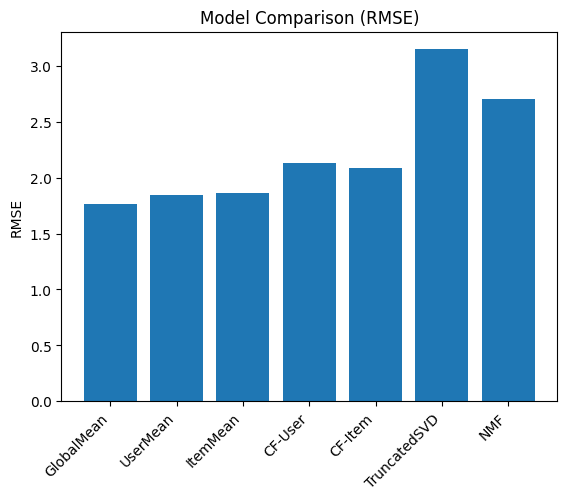

In [12]:
# Plot RMSE
plt.figure()
plt.bar(df_results['Model'], df_results['RMSE'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Model Comparison (RMSE)')
plt.show()


## 11) Recommend for a Sample User

In [13]:
sample_user = int(train['userId'].sample(1, random_state=7).iloc[0])
recs = topn_for_user(sample_user, train, alpha=0.7, N=10)
print('User:', sample_user, '| Top-10 recommendations:', recs)
if items is not None:
    display(items[items['itemId'].isin(recs)][['itemId','title','genres']])


User: 64 | Top-10 recommendations: [np.int64(278), np.int64(67), np.int64(179), np.int64(192), np.int64(172), np.int64(118), np.int64(35), np.int64(92), np.int64(266), np.int64(223)]


,itemId,title,genres
34,35,Item 35,"Thriller, Sci-Fi, Drama"
66,67,Item 67,"Drama, Sci-Fi"
91,92,Item 92,"Sci-Fi, Thriller, Documentary"
117,118,Item 118,"Drama, Documentary, Comedy"
171,172,Item 172,"Documentary, Comedy, Drama"
178,179,Item 179,"Thriller, Drama, Documentary"
191,192,Item 192,"Drama, Sci-Fi"
222,223,Item 223,"Drama, Sci-Fi"
265,266,Item 266,"Documentary, Action"
277,278,Item 278,"Sci-Fi, Drama, Comedy"


## 12) Save Artifacts (Optional)
Persist factor matrices and similarities for later use (demo purpose).

In [14]:
artifacts = {
    'global_mean': float(global_mean),
    'user_mean_size': len(user_mean),
    'item_mean_size': len(item_mean),
    'svd_components': int(U.shape[1]),
    'nmf_components': int(W.shape[1]),
    'timestamp': datetime.utcnow().isoformat() + 'Z'
}
pd.Series(artifacts).to_json('artifacts_summary.json')
print('Saved artifacts_summary.json')


NameError: name 'datetime' is not defined

### Notes
- To use with **MovieLens**: put `ratings.csv` and `movies.csv` next to this notebook.
- `ratings.csv` should have columns: `userId,itemId,rating` (timestamp optional).
- `movies.csv` should have columns: `itemId,title,genres`.
- For **top-N evaluation**, we treat high-rated items in the test set as relevant.
- For production, consider implicit feedback models, cold-start handling, and online learning with feedback loops.
